# Simulations

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import scipy

In [2]:
# define reward function
def reward():
    # true signal 0.3
    return  0.3 + np.random.normal(0, 1, 1)[0] 


# define function for generating predictable weights w_t
def f(x):
    return 1/np.sqrt(x*np.log(np.exp(2)*x)*np.log(np.log(np.exp(2)*x))**2)
        

# define eps Greedy algorithm
def ECB(n):
    rewards_seq = np.array([reward() for i in range(n)])
    x = [0, 1]
    y = [rewards_seq[0], rewards_seq[1]]
    nums = np.array([1 , 1 ])
    rewards = np.array(y)
    
    for i in range(n-2):
        # compute arm means
        arm_means = rewards/nums
        arm = np.argmax(arm_means)
        flag = np.random.uniform(0,1,1)[0]
        # defining decaying rate
        if flag > 1 - np.log(i+1)**0.5/np.sqrt(i+1) and i>50:
            arm = 1 - arm
        x.append(arm)
        newr = rewards_seq[i+2]
        y.append(newr)
        nums[arm] += 1
        rewards[arm] += newr
    # return the noise sequence
    return x, y, rewards_seq - 0.3

# ALEE concentration vs OLS concentration

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
from scipy.optimize import minimize
def tuning_lam(delta):
    
    def delta_lam_function(x, delta):
        
        return (x+1)*np.log(1/delta**2 + 1/x/delta**2)
    
    res = minimize(delta_lam_function, 1, method='nelder-mead',
               args=(delta), options={'xatol': 1e-4, 'disp': True})
    
    return res.x[0]

In [5]:
def concen_compare(n, sampler, alpha_list):
    CI_data = np.zeros((len(alpha_list),6))
    
    x,y,noise = sampler(n)
    X = np.zeros((n,2))

    # construct X
    for i in range(2):
        X[:,i] = (np.array(x) == i) - 0
        
    # y
    x = np.array(x)
    y = np.array(y)
    
    # compute OLS
    M = LinearRegression( fit_intercept = False).fit(X, y)
    coeff = M.coef_
    
    # estimate std
    y_fit = X@coeff.reshape(-1,1)
    sig_h = np.sqrt(np.mean((y - y_fit.reshape(-1))**2))
    
    coeff = coeff[0]
    Sn = X.T@X
    Sn = Sn[0,0]
    
        
    # extract information for the first arm
    ysub = y[np.array(x) == 0]
    noise_sub = noise[np.array(x) == 0]
    n1 = len(ysub)
    
    # define s0
    s0 = np.exp(2)*np.log(n)
    w = []
    
    # compute weights w
    # consider self-scaled version
    for i in range(n1):
        w.append(f(1 + (i+1)/s0)/np.sqrt(s0))
    w = np.array(w)
    
    # ALEE concentration with lambda = 0.1
    alee = 1/(np.sum(w))*np.sum(w*ysub)
    for i in range(len(alpha_list)):
        alpha = alpha_list[i]
        lam0 = tuning_lam(alpha)
        
        concen_two = 1/np.sum(w)*sig_h*np.sqrt((lam0 + np.sum(w**2))*np.log((lam0+np.sum(w**2))/(lam0*alpha**2)))
        CI_data[i,5] += 2*concen_two
        
        alpha = 2*alpha
        concen_one = 1/np.sum(w)*sig_h*np.sqrt((lam0 + np.sum(w**2))*np.log((lam0+np.sum(w**2))/(lam0*alpha**2)))
        U1 = alee + concen_one
        L1 = alee - concen_one
        U1 = (U1 >= 0.3) - 0
        L1 = (L1 <= 0.3) - 0
        CI_data[i,3] += U1
        CI_data[i,4] += L1
   
        
    
    # OLS concentration
    for i in range(len(alpha_list)):
        alpha = alpha_list[i]
        
        ####################################################################
        # constant c here
        c = 1
        d = 2
        con_f = 2*(1 + 1/np.log(n))*np.log(1/alpha) + c*d*np.log(d*np.log(n))
        con_delta = sig_h*np.sqrt(1/Sn*con_f)
        CI_data[i,2] += 2*con_delta
        
        # one-sided
        con_f = 2*(1 + 1/np.log(n))*np.log(0.5/alpha) + c*d*np.log(d*np.log(n))
        con_delta = sig_h*np.sqrt(1/Sn*con_f)
        U1 = coeff + con_delta
        L1 = coeff - con_delta
        U1 = (U1 >= 0.3) - 0
        L1 = (L1 <= 0.3) - 0
        CI_data[i,0] += U1
        CI_data[i,1] += L1
    
    return CI_data
    
#   replication function
def CI_repli(N , n,  f, alpha_list):
    Data = np.zeros((N, len(alpha_list)*6))
    for i in range(N):
        output = concen_compare(n, f, alpha_list)
        Data[i,:] = output.reshape(-1)
    al = len(alpha_list)
    Data1 = np.mean(Data, axis = 0).reshape(al, 6)
    Data2 = np.std(Data, axis = 0).reshape(al, 6)
    return Data1, Data2/np.sqrt(N)

In [6]:
def coverage_plot(E, SE, alpha_list,  title_text):
    sns.set(rc={'figure.figsize':(8,8)})
    sns.set_style("white")
    
    # marker size
    marks = 17
    
    # color list
    clist = ['darkblue', 'green']
        
    data = np.concatenate((1- alpha_list.reshape(-1,1), E), axis = 1)
    df = pd.DataFrame(data, columns = ['alpha','OLS', 'ALEE'])
    

    
    
    sns.lineplot(data = df, x= 'alpha', y= 'OLS', color = clist[0], label = 'OLS', marker = '>', markersize=marks, \
                 linestyle='dashed')
    plt.errorbar(x= data[:,0], y=  E[:,0] , yerr = SE[:,0], color = clist[0],  capsize = 3)
    
    
    sns.lineplot(data = df, x= 'alpha', y= 'ALEE', color = clist[1], label = 'ALEE', marker = 'o', markersize=marks, \
                 linestyle='dashed')
    plt.errorbar(x= data[:,0], y=  E[:,1] , yerr = SE[:,1], color = clist[1],  capsize = 3)
    
    
    
    title_font = 29
    y_pos = 1.02
    
    plt.title(title_text, fontsize = title_font, y = y_pos)
    plt.ylabel('Empirical coverage probability', fontsize= 23)
    plt.xlabel('Target coverage probability', fontsize = 23)
    plt.yticks(np.arange(0.95, 1, step=0.01), fontsize = 18)
    plt.xticks(np.arange(0.75, 1, step=0.05), fontsize = 18)
    plt.legend(prop={'size': 21}, loc = 4)
    
    
    
def width_plot(E, SE, alpha_list, title_text, ydelta, width_min, width_max):
    sns.set(rc={'figure.figsize':(8,8)})
    sns.set_style("white")
    
    # marker size
    marks = 17
    
    # color list
    clist = ['darkblue', 'green']
        
    data = np.concatenate((1- alpha_list.reshape(-1,1), E), axis = 1)
    df = pd.DataFrame(data, columns = ['alpha','OLS', 'ALEE'])
    
    
    sns.lineplot(data = df, x= 'alpha', y= 'OLS', color = clist[0], label = 'OLS', marker = '>', markersize=marks, \
                 linestyle='dashed')
    plt.errorbar(x= data[:,0], y=  E[:,0] , yerr = SE[:,0], color = clist[0],  capsize = 3)
    
    
    sns.lineplot(data = df, x= 'alpha', y= 'ALEE', color = clist[1], label = 'ALEE', marker = 'o', markersize=marks, \
                 linestyle='dashed')
    plt.errorbar(x= data[:,0], y=  E[:,1] , yerr = SE[:,1], color = clist[1],  capsize = 3)
    

    
    y_pos = 1.02
    plt.title(title_text, fontsize = 29, y = y_pos)
    

    
    plt.ylabel('Mean width of CI', fontsize= 23)
    plt.xlabel('Target coverage probability', fontsize = 23)
    plt.xticks(np.arange(0.75, 1, step=0.05), fontsize = 18)
    plt.yticks(np.arange(width_min + ydelta, width_max, step= ydelta), fontsize = 18)
    plt.legend(prop={'size': 21}, loc = 2)
     

In [7]:
np.random.seed(666)
Data1, Data2 = CI_repli(1000, 1000, ECB,  np.arange(0.05,0.26,0.015))

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         F

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5

Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         F

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.012760
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.838751
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.675513
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.521675
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 5.376113
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.618534
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.400251
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 6.199223
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 9.211968
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.620929
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.149402
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.756257
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.418531
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 7.122083
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 6.857580
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

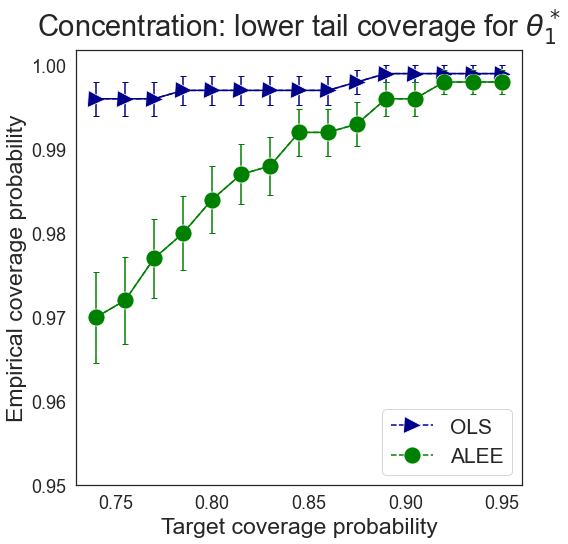

In [8]:
alpha_list = np.arange(0.05,0.26,0.015)
coverage_plot(Data1[:,[0,3]], Data2[:,[0,3]] , alpha_list, r'Concentration: lower tail coverage for $\theta_1^*$')
plt.savefig('ALEE_OLS_concen_lower.pdf')

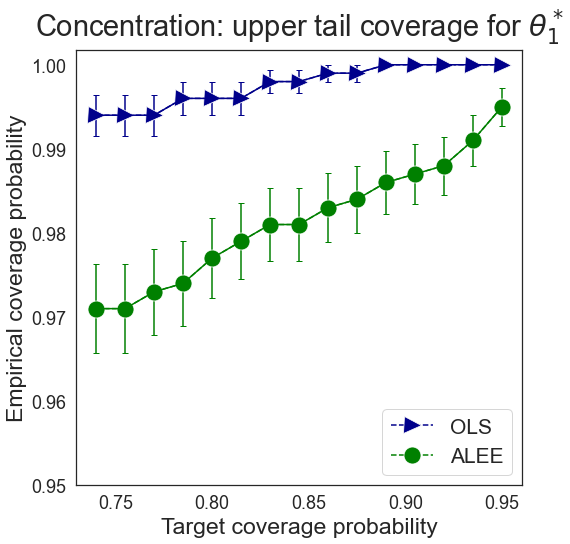

In [9]:
coverage_plot(Data1[:,[1,4]], Data2[:,[1,4]], alpha_list, r'Concentration: upper tail coverage for $\theta_1^*$')
plt.savefig('ALEE_OLS_concen_upper.pdf')

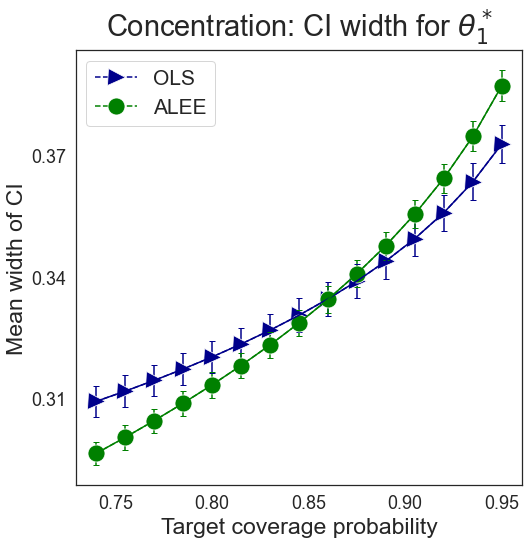

In [10]:
width_plot(Data1[:,[2,5]], Data2[:,[2,5]], alpha_list, r'Concentration: CI width for $\theta_1^*$', 0.03, 0.28,0.4)
plt.savefig('ALEE_OLS_concen_width.pdf')